# Forecasting

In [1]:
from pygsig.datasets.subduction import SubductionZone
import pandas as pd

dataset = SubductionZone(poly_path='datasets/subduction/polygon.geojson',
                         rast_path='datasets/subduction/interface.grd',
                         label_path='datasets/subduction/nonlinear.json',
                         data_path='datasets/subduction/data.geojson',
                         site_path='datasets/subduction/location_small.geojson',
                         start_date=pd.Timestamp('2016-01-01 11:59:00+0000', tz='UTC'),
                         end_date=pd.Timestamp('2019-12-31 11:59:00+0000', tz='UTC'),
                         download=True)

100%|██████████| 86/86 [02:54<00:00,  2.03s/it]


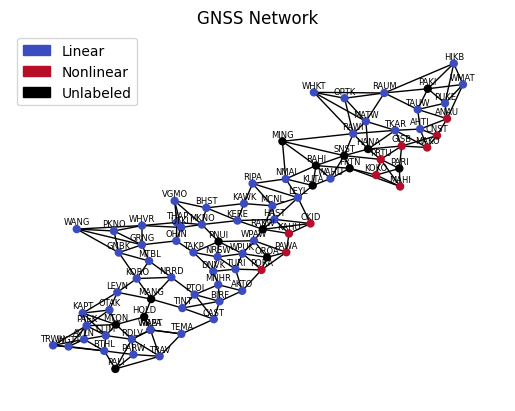

In [8]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# get graph

dataset.task = 'classification'
seq = dataset.get_graph(k=4)

blue = '#3b4cc0'
red = '#b70d28'

G = nx.Graph()
G.add_nodes_from(range(seq.num_nodes))
G.add_edges_from(seq[0].edge_index.T.tolist())

pos = {node: position.numpy() for node, position in enumerate(seq[0].pos)}
depth = {node: measurement.item() for node, measurement in enumerate(seq[0].y)}
vector_depth = np.array([depth[i] for i in range(len(depth))])

# Define color map based on labels
color_map = {0: blue, -1: 'black', 1: red}
node_colors = [color_map[depth[node]] for node in G.nodes]

plt.figure()
nx.draw_networkx_nodes(G, pos=pos, node_size=25, node_color=node_colors)
nx.draw_networkx_edges(G, pos=pos)
nx.draw_networkx_labels(G, pos={k: (v[0], v[1] + 10000) for k, v in pos.items()}, labels={i: dataset.stations[i] for i in range(len(dataset.stations))}, font_size=6)
plt.title('GNSS Network')
plt.axis('off')

# Create legend
import matplotlib.patches as mpatches
linear_patch = mpatches.Patch(color=blue, label='Linear')
nonlinear_patch = mpatches.Patch(color=red, label='Nonlinear')
unlabeled_patch = mpatches.Patch(color='black', label='Unlabeled')
plt.legend(handles=[linear_patch, nonlinear_patch, unlabeled_patch])
plt.show()


In [79]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import GConvLSTM,GConvGRU

class STGNN_LSTM(torch.nn.Module):
    def __init__(self, node_features, hidden_features, filter_size):
        super(STGNN_LSTM, self).__init__()
        self.recurrent = GConvLSTM(in_channels=node_features,
                                   out_channels=hidden_features,
                                     K=filter_size)
        self.linear = torch.nn.Linear(in_features=hidden_features, out_features=1)

    def forward(self, x, edge_index, edge_weight,h,c):
        h_0, c_0 = self.recurrent(x, edge_index, edge_weight, h, c)
        h = F.relu(h_0)
        h = self.linear(h)
        return h, h_0, c_0

class STGNN_GRU(torch.nn.Module):
    def __init__(self, node_features, hidden_features, filter_size):
        super(STGNN_GRU, self).__init__()
        self.recurrent = GConvGRU(in_channels=node_features,
                                   out_channels=hidden_features,
                                     K=filter_size)
        self.linear = torch.nn.Linear(in_features=hidden_features, out_features=1)

    def forward(self, x, edge_index, edge_weight,h):
        h_0 = self.recurrent(x, edge_index, edge_weight, h)
        h = F.relu(h_0)
        h = self.linear(h)
        return h, h_0

<Figure size 640x480 with 0 Axes>

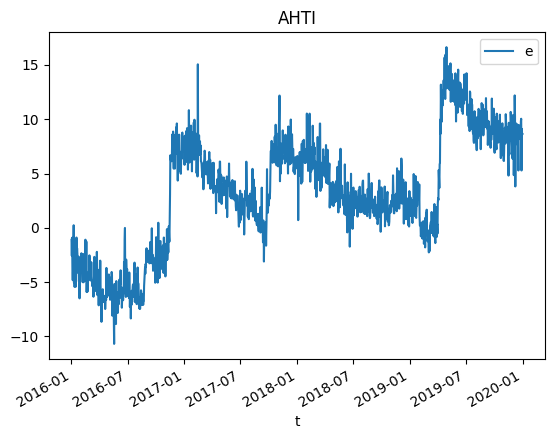

<Figure size 640x480 with 0 Axes>

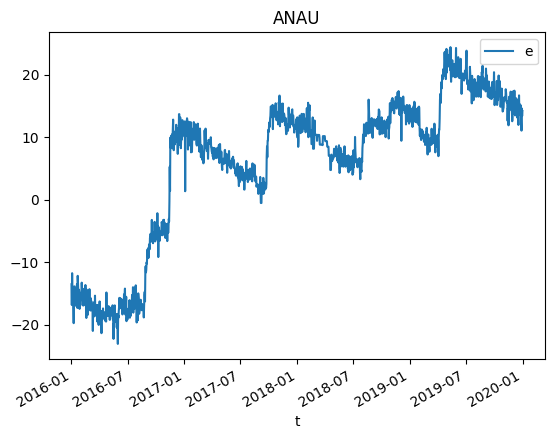

<Figure size 640x480 with 0 Axes>

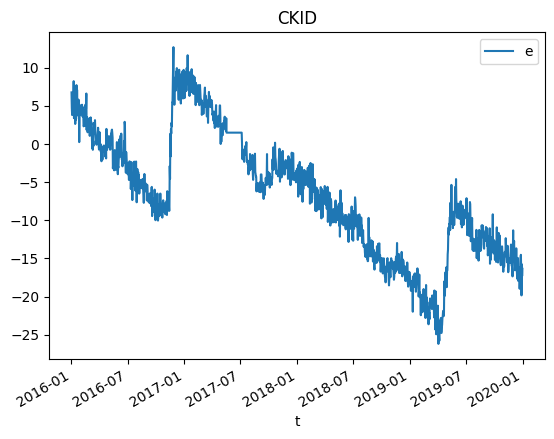

<Figure size 640x480 with 0 Axes>

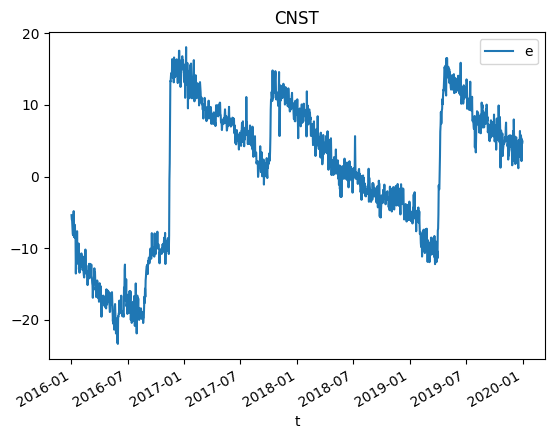

<Figure size 640x480 with 0 Axes>

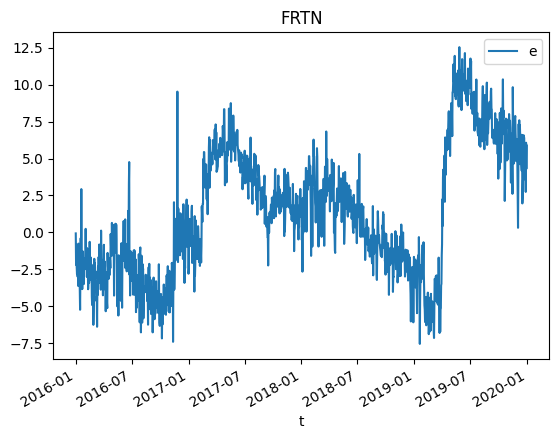

<Figure size 640x480 with 0 Axes>

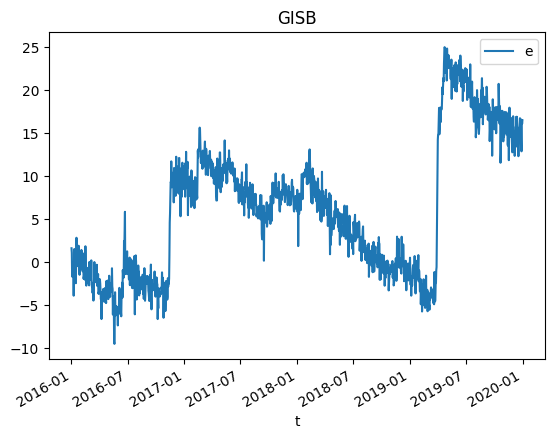

<Figure size 640x480 with 0 Axes>

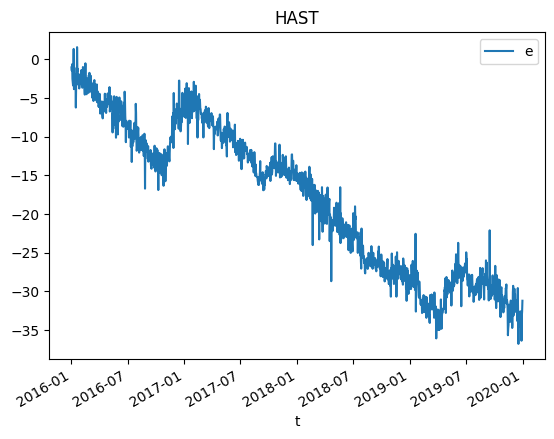

<Figure size 640x480 with 0 Axes>

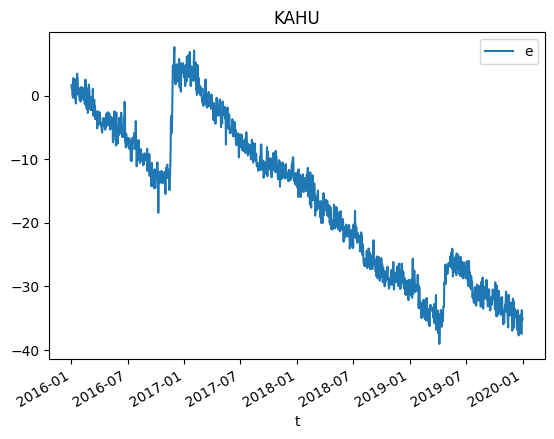

<Figure size 640x480 with 0 Axes>

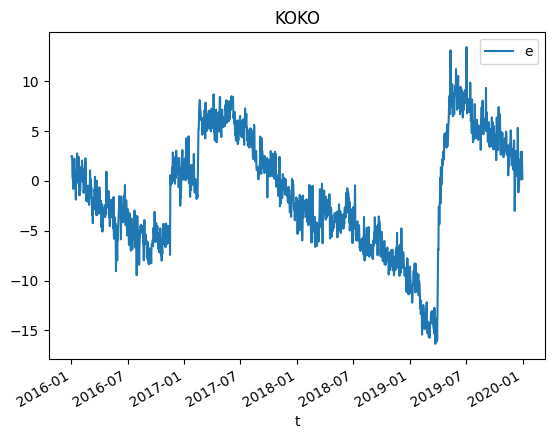

<Figure size 640x480 with 0 Axes>

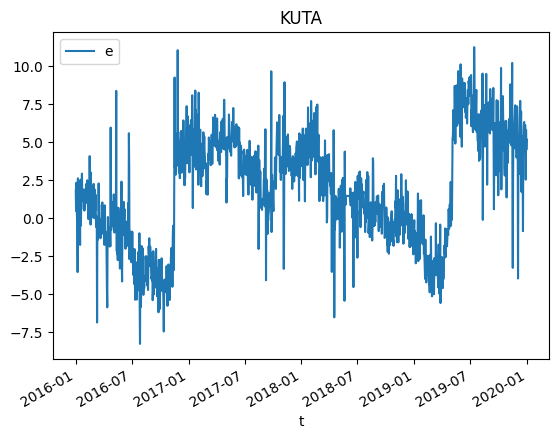

<Figure size 640x480 with 0 Axes>

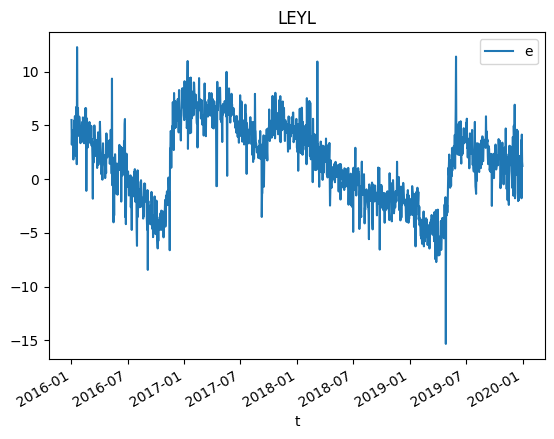

<Figure size 640x480 with 0 Axes>

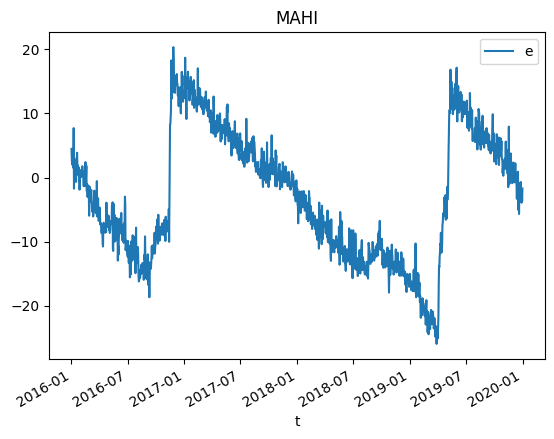

<Figure size 640x480 with 0 Axes>

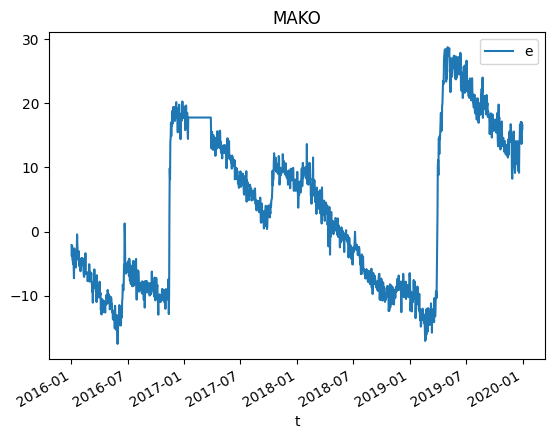

<Figure size 640x480 with 0 Axes>

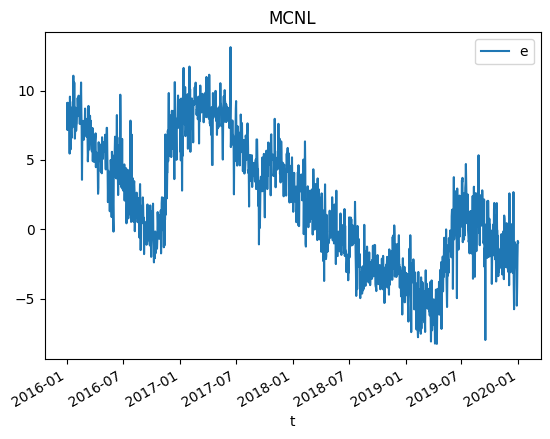

<Figure size 640x480 with 0 Axes>

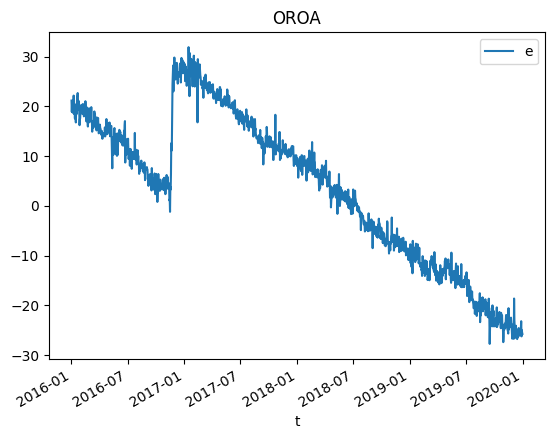

<Figure size 640x480 with 0 Axes>

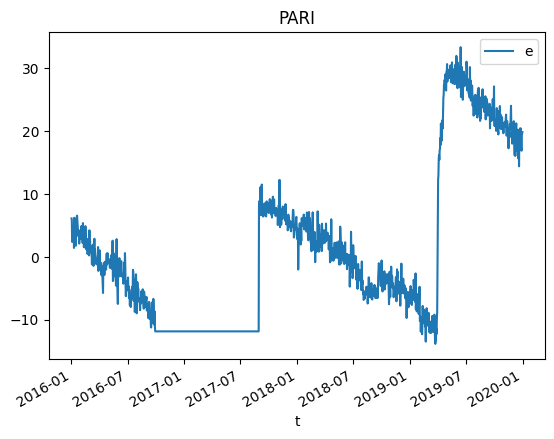

<Figure size 640x480 with 0 Axes>

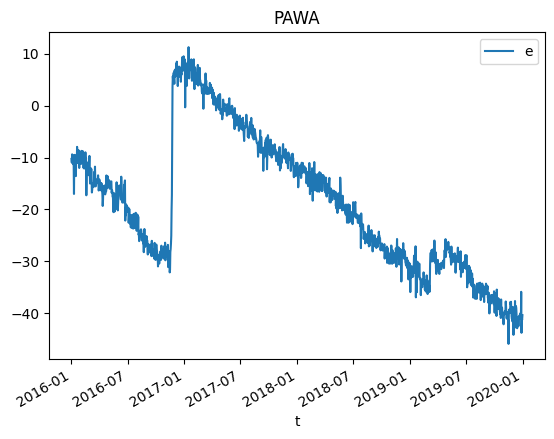

<Figure size 640x480 with 0 Axes>

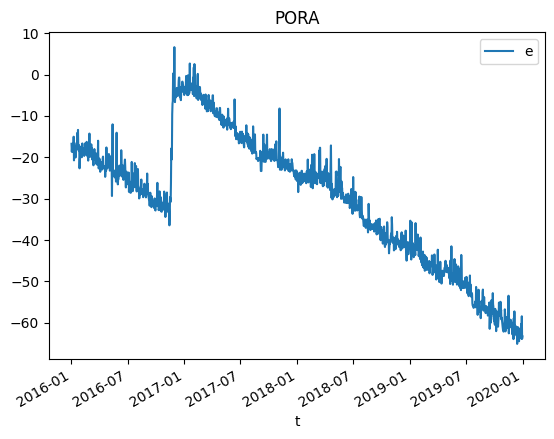

<Figure size 640x480 with 0 Axes>

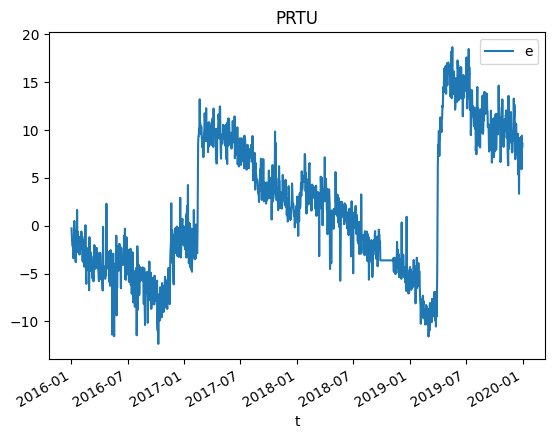

<Figure size 640x480 with 0 Axes>

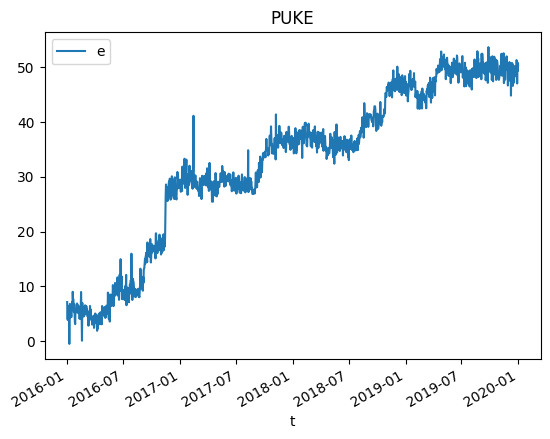

<Figure size 640x480 with 0 Axes>

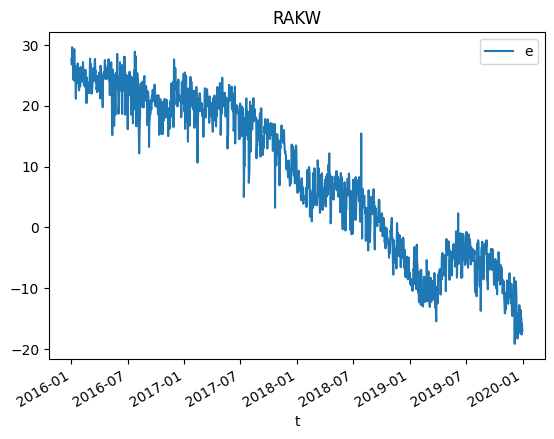

<Figure size 640x480 with 0 Axes>

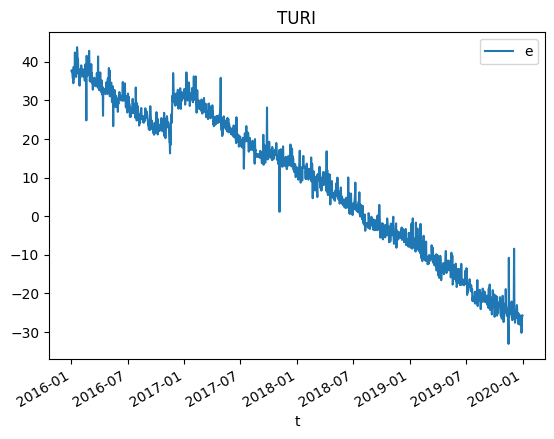

<Figure size 640x480 with 0 Axes>

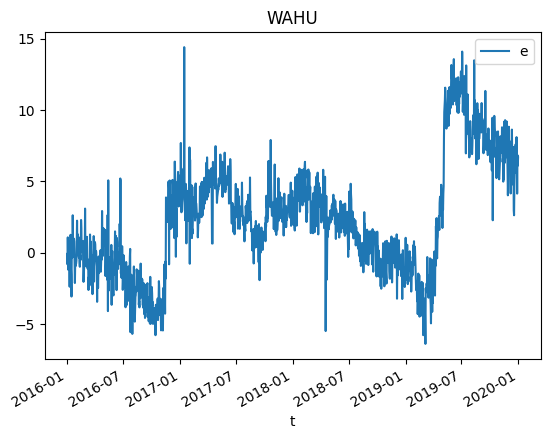

<Figure size 640x480 with 0 Axes>

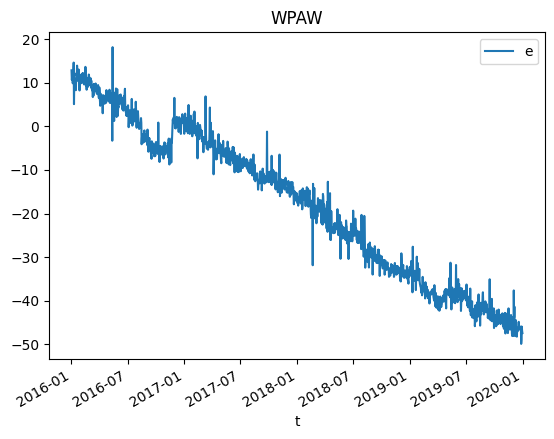

<Figure size 640x480 with 0 Axes>

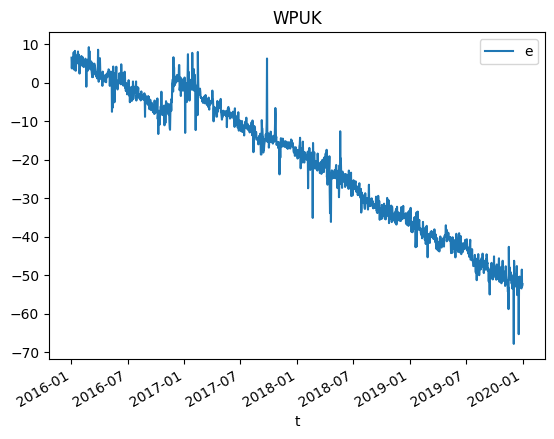

In [ ]:
for siteID in dataset.df.siteID.unique():
    plt.figure(figsize=(10, 5))
    dataset.df.loc[dataset.df.siteID == siteID][['t','e']].plot(x='t',y='e')
    plt.title(f'{siteID}')
    plt.show()

100%|██████████| 500/500 [02:11<00:00,  3.79it/s]


MSE: 1.0483


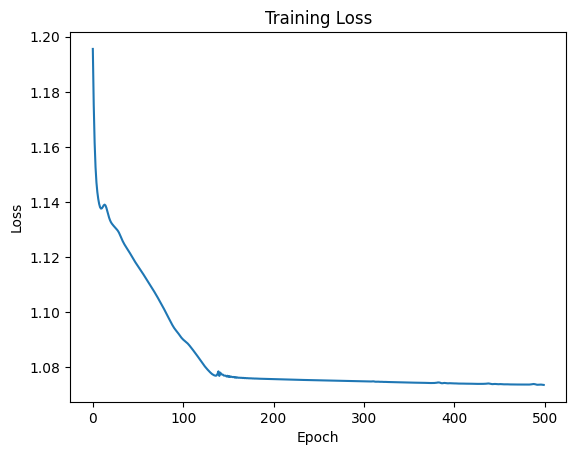

In [98]:
from tqdm import tqdm
import torch
import torch.nn.functional as F
from torch_geometric_temporal.signal import temporal_signal_split

dataset.task = 'forecasting'
seq = dataset.get_graph(r=60e3,normalize=True,lag=16)
train_dataset, test_dataset = temporal_signal_split(seq, train_ratio=0.2)

model = STGNN_GRU(node_features=16, hidden_features=64, filter_size=1)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 500
print_statements = False
training_curve = True

model.train()

train_loss = []
for epoch in tqdm(range(num_epochs),disable=print_statements):
    cost = 0
    h = None
    for time, snapshot in enumerate(train_dataset):
        y_hat, h = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr,h)
        cost = cost + torch.mean((y_hat-snapshot.y)**2)
    cost = cost / (time+1)
    cost.backward()
    optimizer.step()
    optimizer.zero_grad()
    if print_statements:
        print('Epoch: {:03d}/{:03d}, Loss: {:.4f}'.format(epoch+1,num_epochs, cost.item()))    
    if training_curve:
        train_loss.append(cost.item())
model.eval()
cost = 0
forecast = torch.zeros(test_dataset.num_nodes,test_dataset.snapshot_count)
ground_truth = torch.zeros(test_dataset.num_nodes,test_dataset.snapshot_count)
h, c = None, None
for time, snapshot in enumerate(test_dataset):
    y_hat, h = model(snapshot.x, snapshot.edge_index,snapshot.edge_attr, h)
    cost = cost + torch.mean((y_hat-snapshot.y)**2)
    forecast[:,time] = y_hat.squeeze().detach()
    ground_truth[:,time] = snapshot.y
cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))

if training_curve:
    plt.figure()
    plt.plot(train_loss)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

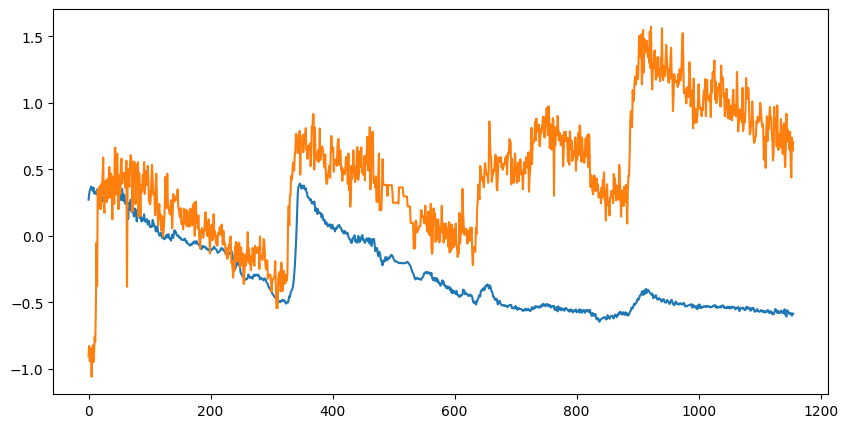

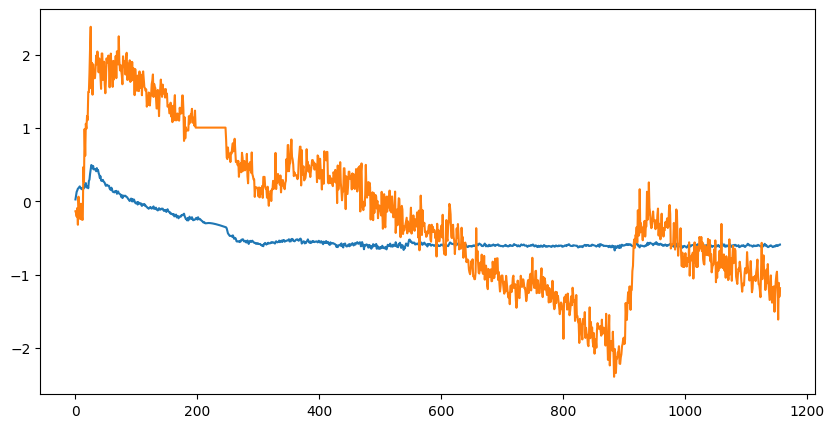

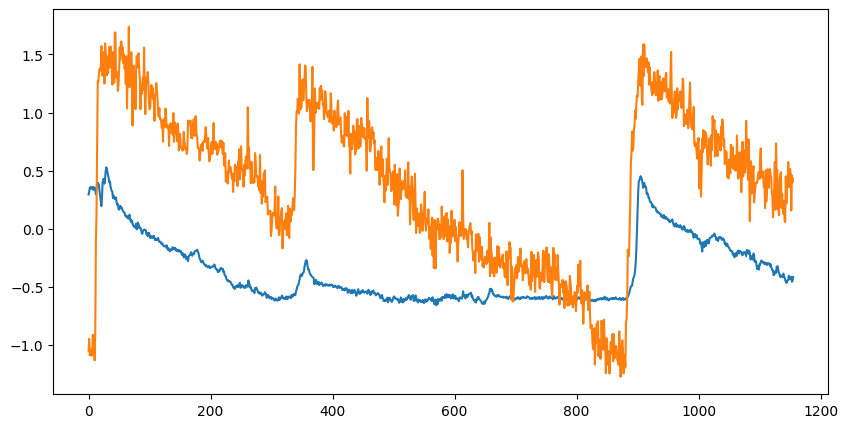

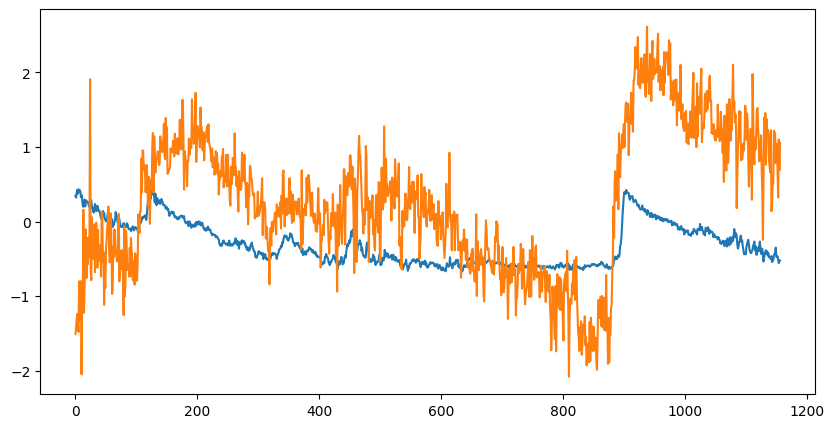

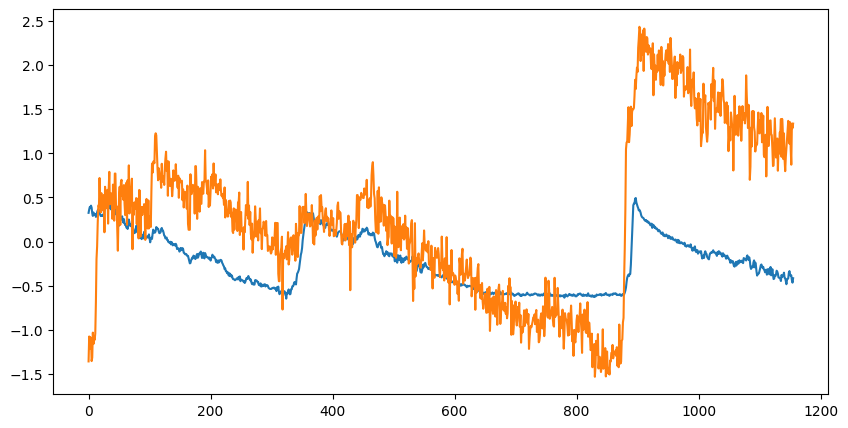

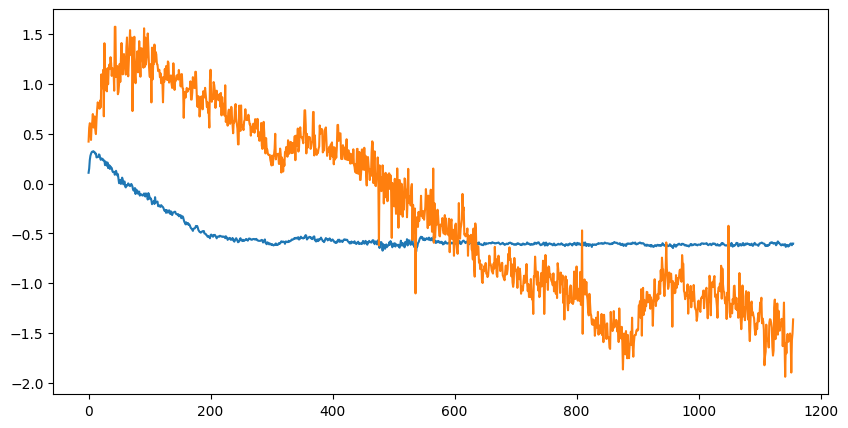

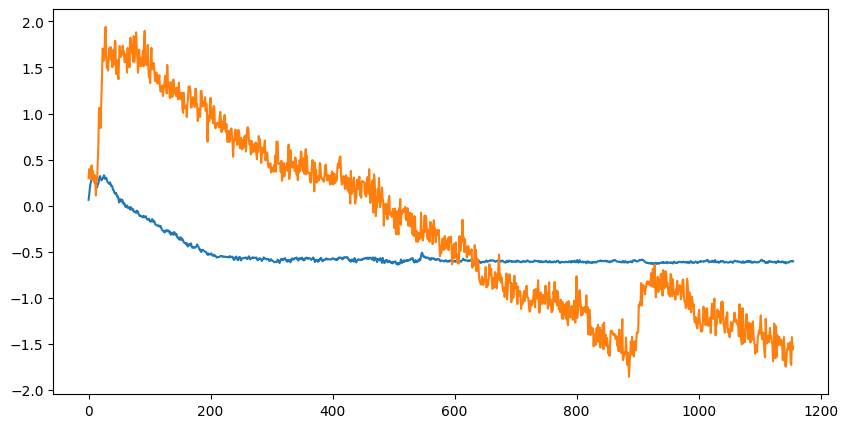

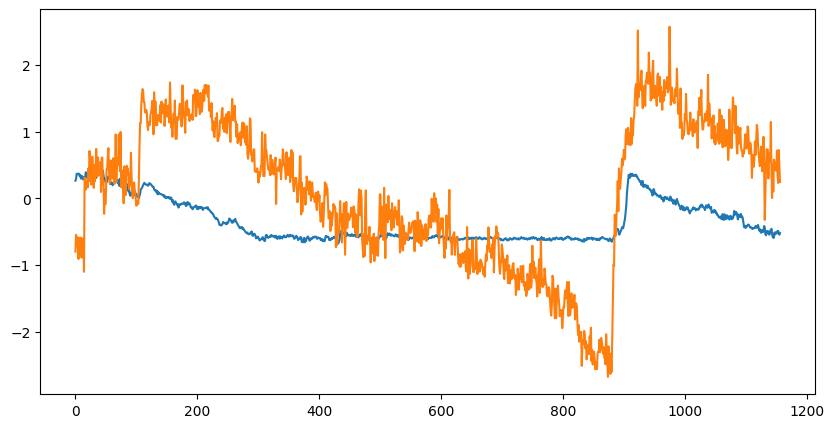

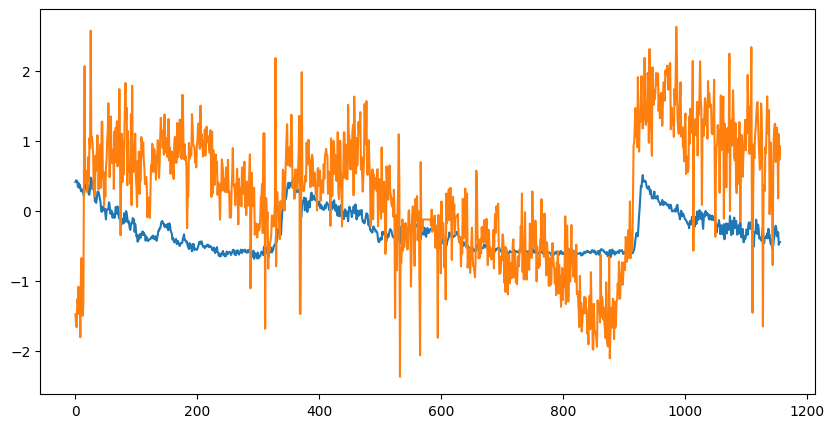

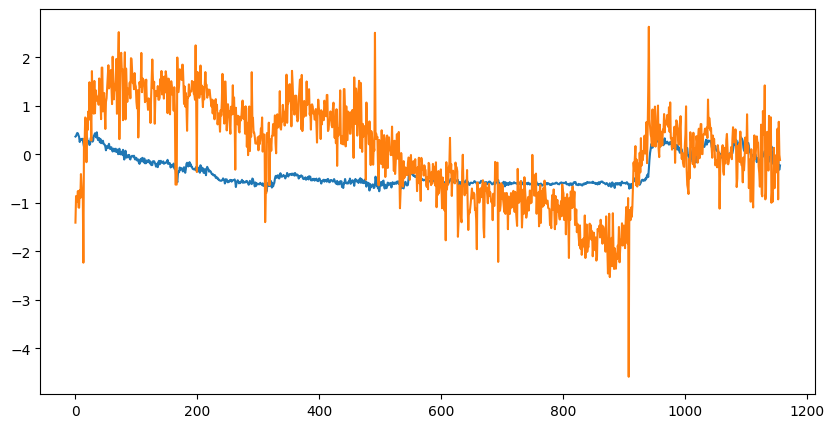

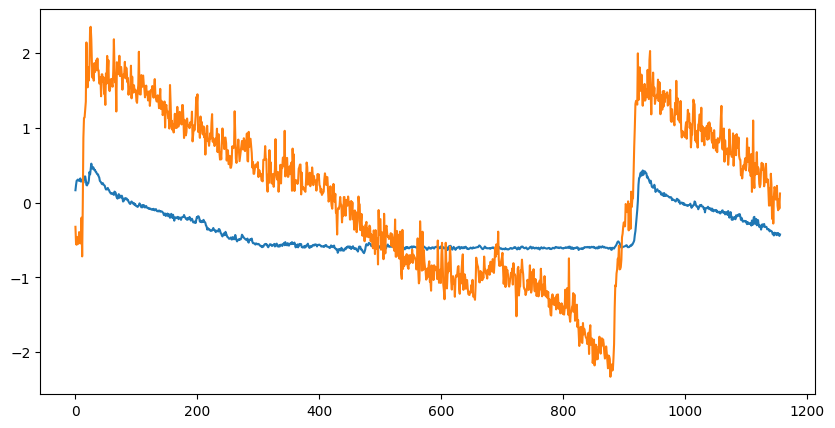

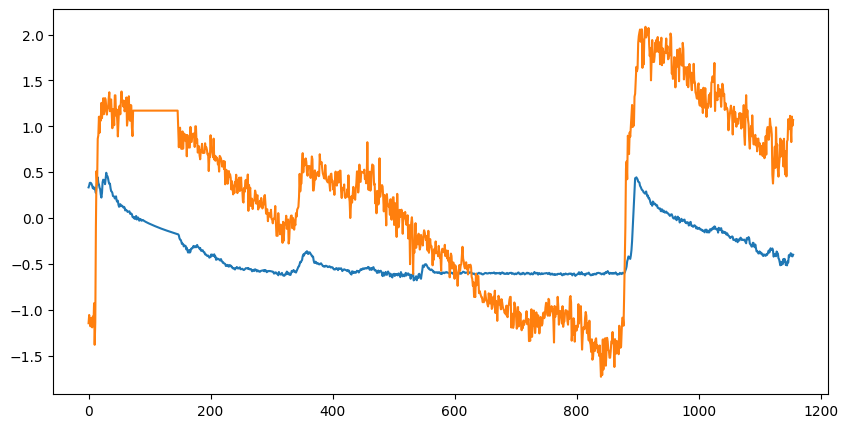

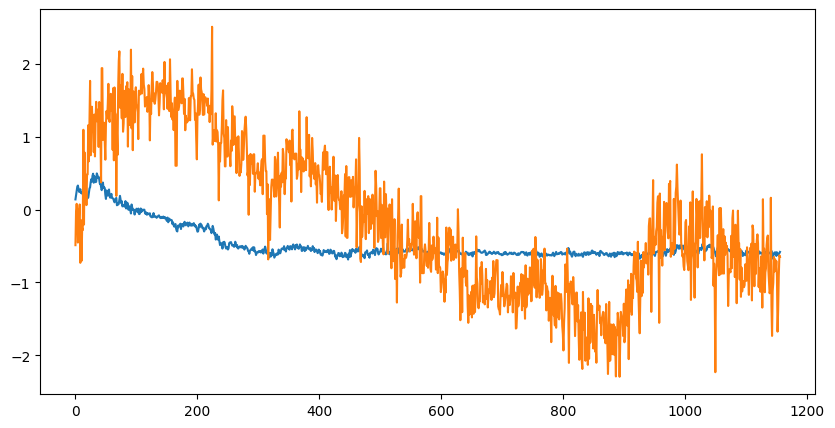

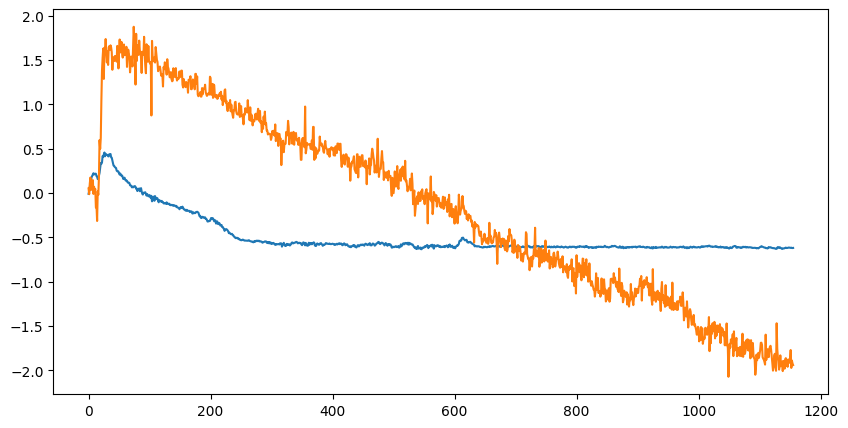

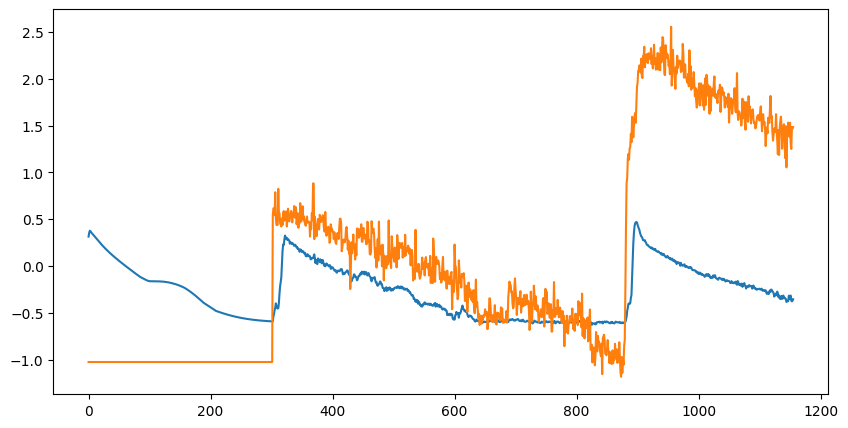

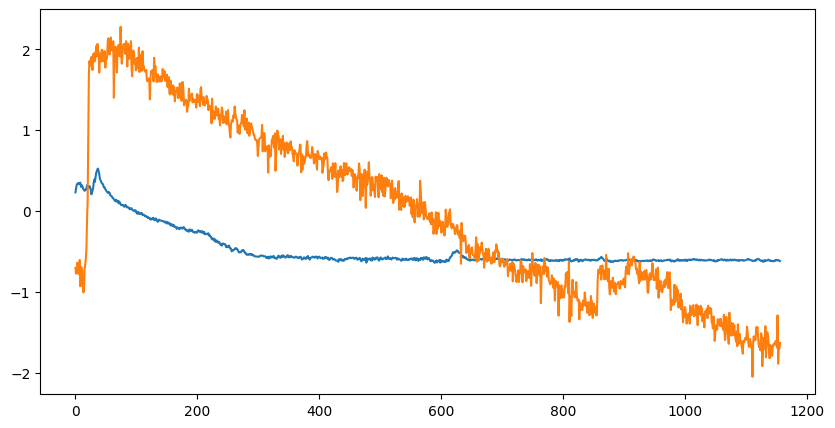

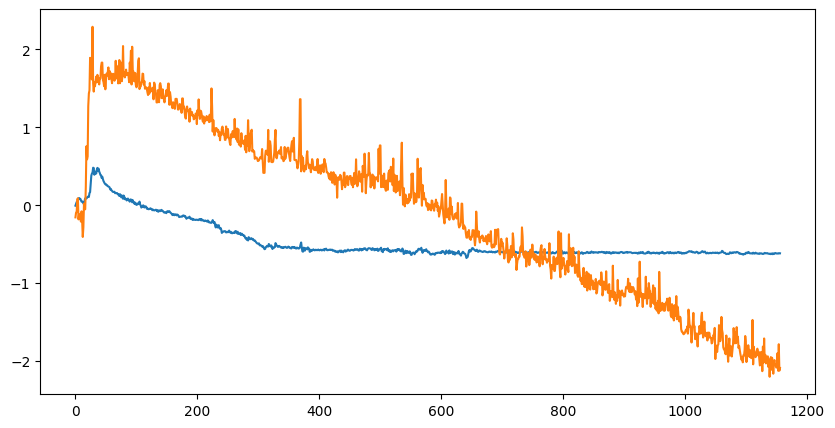

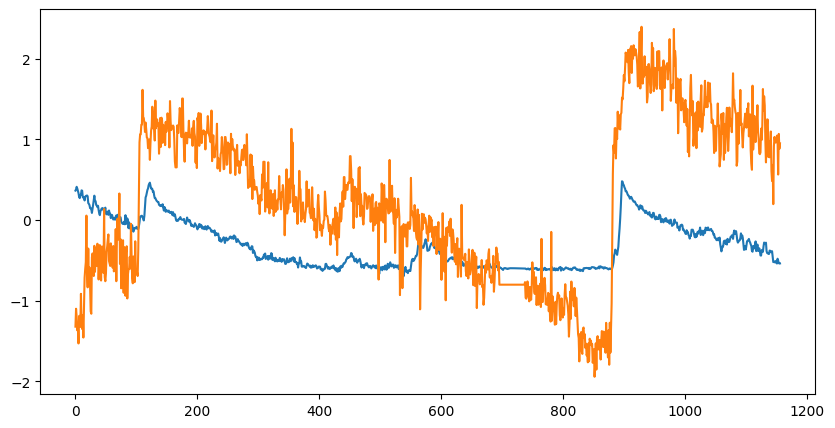

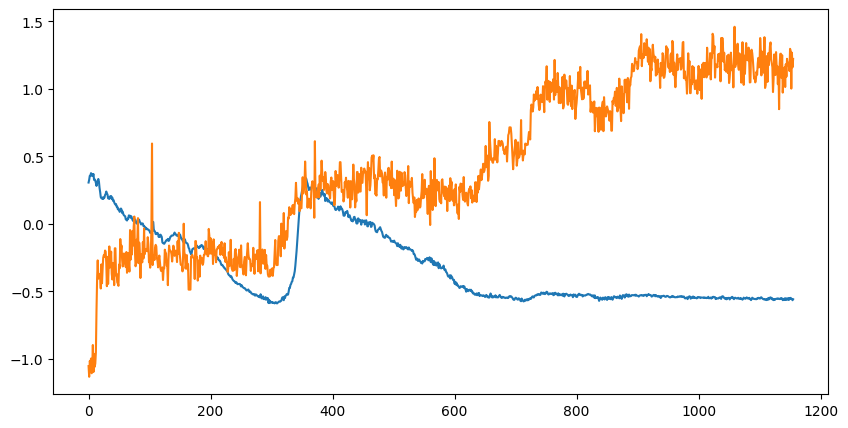

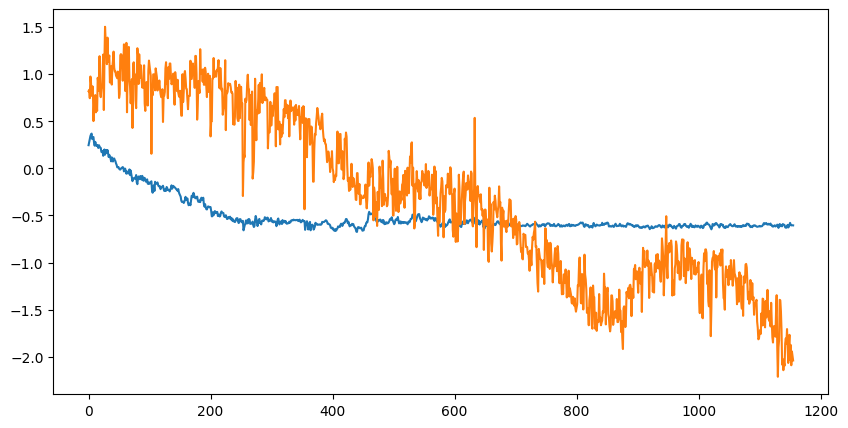

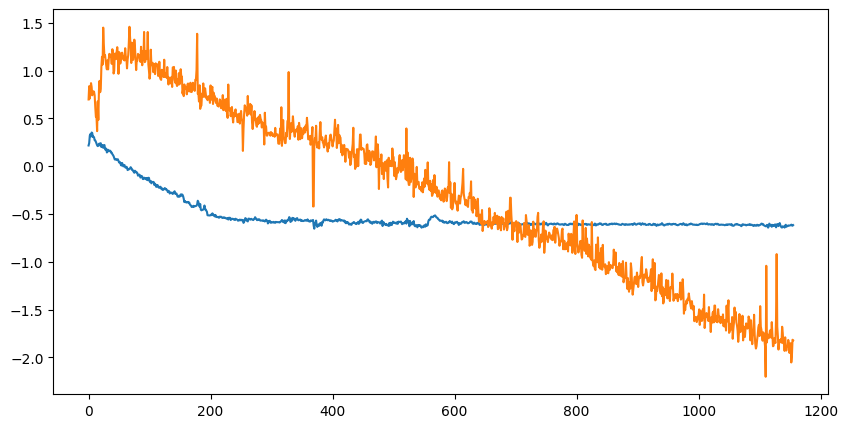

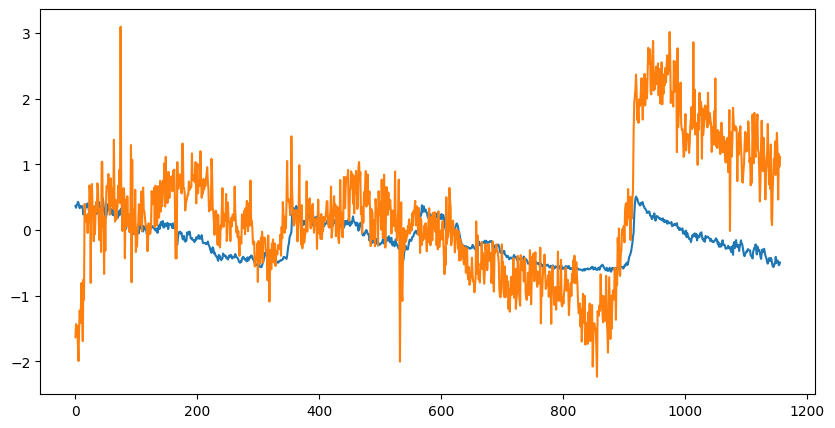

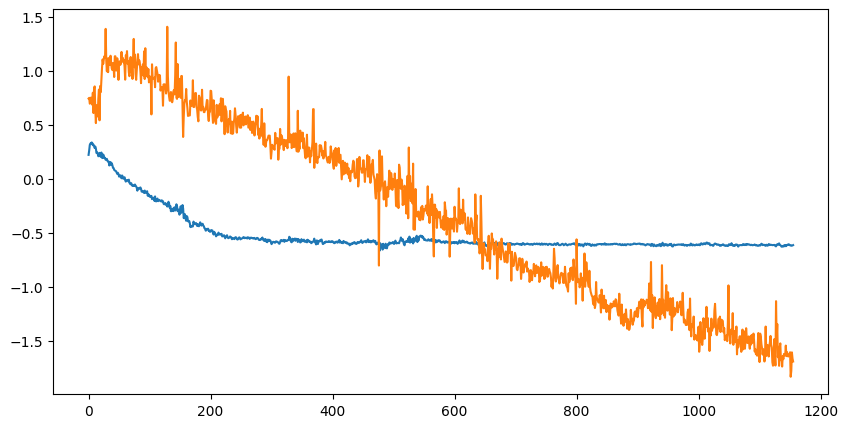

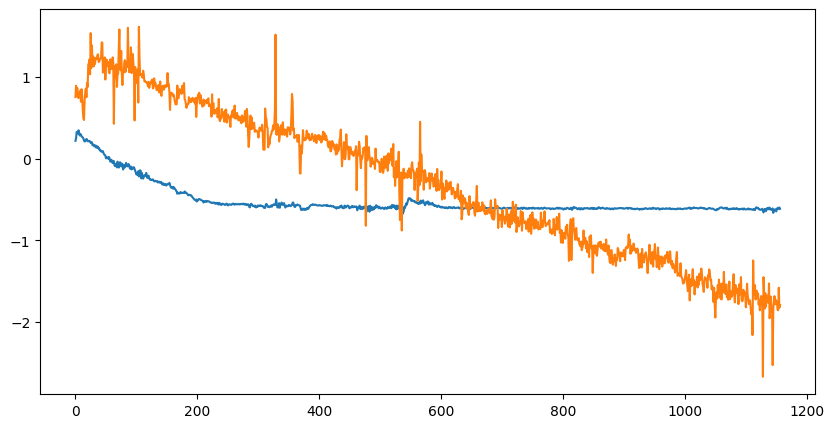

In [99]:
import matplotlib.pyplot as plt

nodes = np.arange(1,seq.num_nodes)
for node in nodes:
    plt.figure(figsize=(10, 5))
    plt.plot(forecast[node].numpy(), label='Forecast')
    plt.plot(ground_truth[node].numpy(), label='Ground Truth')
    plt.show()